In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

# Importing the age distribution and cleaning

This section imports the census data on the age distribution in the US

In [2]:
age_dist = pd.read_csv('data/census/PEP_2017_PEPSYASEXN_with_ann.csv')

# Here are the labels used for the different genders
age_dist['Sex.display-label']

0           Sex
1    Both Sexes
2        Female
3          Male
Name: Sex.display-label, dtype: object

In [3]:
# This is a very messy dataset, which contains all the columns for ages from 2010 to 2017, for ages 0 to 100
# Filter down to the most recent result: 2017
filtered_column_names = [colname for colname in age_dist.columns if 'est72017_age' in colname]
column_name_map = {c:c.split('age')[1] for c in filtered_column_names}

In [4]:
age_dist2017 = age_dist[filtered_column_names].rename(columns = column_name_map)

# column 999 contains the total, drop it
age_dist2017.drop('999', axis=1, inplace=True)

# row 0 is also irrelevant, it is the description of the column
age_dist2017.drop(0, axis=0, inplace=True)

age_dist2017['gender'] = age_dist['Sex.display-label']
age_dist2017.set_index('gender', inplace=True)

In [5]:
age_dist2017_clean = age_dist2017.T.reset_index().rename(columns={'index': 'age'})

for numeric_column in ['Both Sexes', 'Female', 'Male']:
    age_dist2017_clean[numeric_column] = age_dist2017_clean[numeric_column].astype(int)
    age_dist2017_clean[numeric_column] = age_dist2017_clean[numeric_column]/age_dist2017_clean[numeric_column].sum()

In [6]:
age_dist2017_clean.head()

gender,age,Both Sexes,Female,Male
0,0,0.012094,0.011640,0.012563
1,1,0.012205,0.011757,0.012666
2,2,0.012347,0.011888,0.012821
3,3,0.012301,0.011834,0.012783
4,4,0.012268,0.011819,0.012730


In [7]:
age_dist2017_clean = age_dist2017_clean.drop('age',axis=1).reset_index().rename(columns={'index': 'age'})

In [8]:
age_dist2017_clean.head()

gender,age,Both Sexes,Female,Male
0,0,0.012094,0.011640,0.012563
1,1,0.012205,0.011757,0.012666
2,2,0.012347,0.011888,0.012821
3,3,0.012301,0.011834,0.012783
4,4,0.012268,0.011819,0.012730


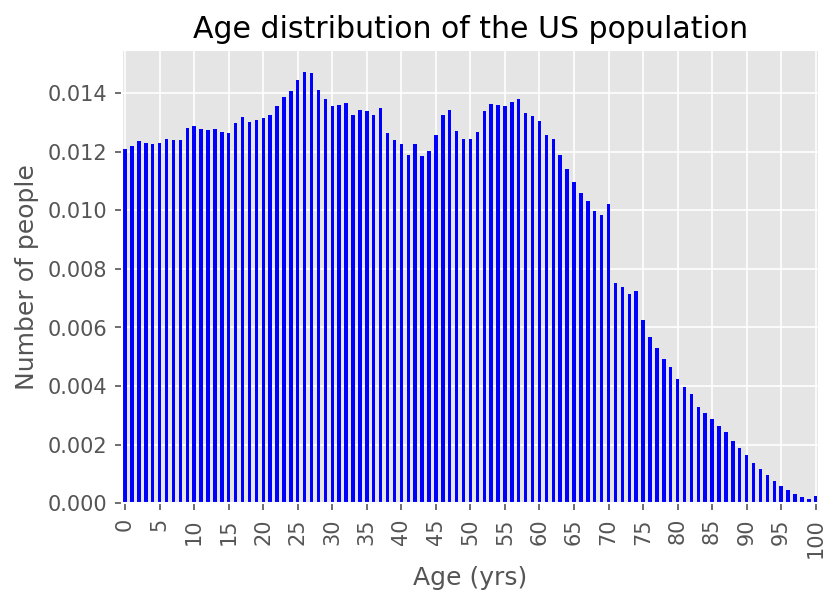

In [9]:

plt.figure(dpi = 150)
age_dist2017_clean['Both Sexes'].plot.bar(color='blue')
plt.xlabel('Age (yrs)')
plt.ylabel('Number of people');
plt.title('Age distribution of the US population')
plt.xticks(np.arange(0,101,5),np.arange(0,101,5));

## Census names

This section reads in the name data from the Social Security Administration

In [10]:
import glob
import re

year_extract = re.compile('\d+')

name_df_list = []
for filename in glob.glob('data/names/yob*.txt'):
    year_number = year_extract.search(filename).group(0)
    df = pd.read_csv(filename, header=None, names=['name', 'gender', 'count'])
    df['year'] = int(year_number)
    df['age'] = 2017 - int(year_number)
    name_df_list.append(df)

In [11]:
name_df = pd.concat(name_df_list)
name_df.sort_values(['year', 'gender', 'name'], inplace=True)

# now free up the memory from the entire list of dfs
del name_df_list

In [12]:
name_df['fraction'] = name_df.groupby(['gender', 'year'])['count'].transform(lambda row: row/row.sum())
name_df.head()

,name,gender,count,year,age,fraction
177,Abbie,F,71,1880,137,0.000780
737,Abby,F,6,1880,137,0.000066
491,Abigail,F,12,1880,137,0.000132
32,Ada,F,652,1880,137,0.007165
325,Adah,F,24,1880,137,0.000264


In [13]:
def filter_frame(name, gender):
    filtered = name_df[(name_df['name'] == name) & (name_df['gender'] == gender)]
    return filtered

filter_frame('Damien', 'M').head()

,name,gender,count,year,age,fraction
8084,Damien,M,6,1936,81,0.000006
8240,Damien,M,6,1938,79,0.000005
7031,Damien,M,13,1940,77,0.000011
7601,Damien,M,9,1941,76,0.000007
8370,Damien,M,7,1942,75,0.000005


## Age distribution

Now we have our datasets read in, we can now find the distribution of ages given a name and gender.

Ultimately this section will create a function `make_plot(name, gender)` that will take a person's name and gender (`M` or `F`), and will produce the plot of age distributions.

In [14]:
def naive_bayes(name, gender):
    filtered = filter_frame(name, gender)
    if gender == 'M':
        population = age_dist2017_clean[['age','Male']].rename(columns={'Male': 'prior'})
    else:
        population = age_dist2017_clean[['age','Female']].rename(columns={'Female': 'prior'})
    
    merged_sets = pd.merge(filtered, population,on='age')
    merged_sets['liklihood_prior'] = merged_sets['fraction'] * merged_sets['prior']
    merged_sets['probability'] = merged_sets['liklihood_prior'] / merged_sets['liklihood_prior'].sum() 
    return merged_sets


damien = naive_bayes('Damien', 'M')

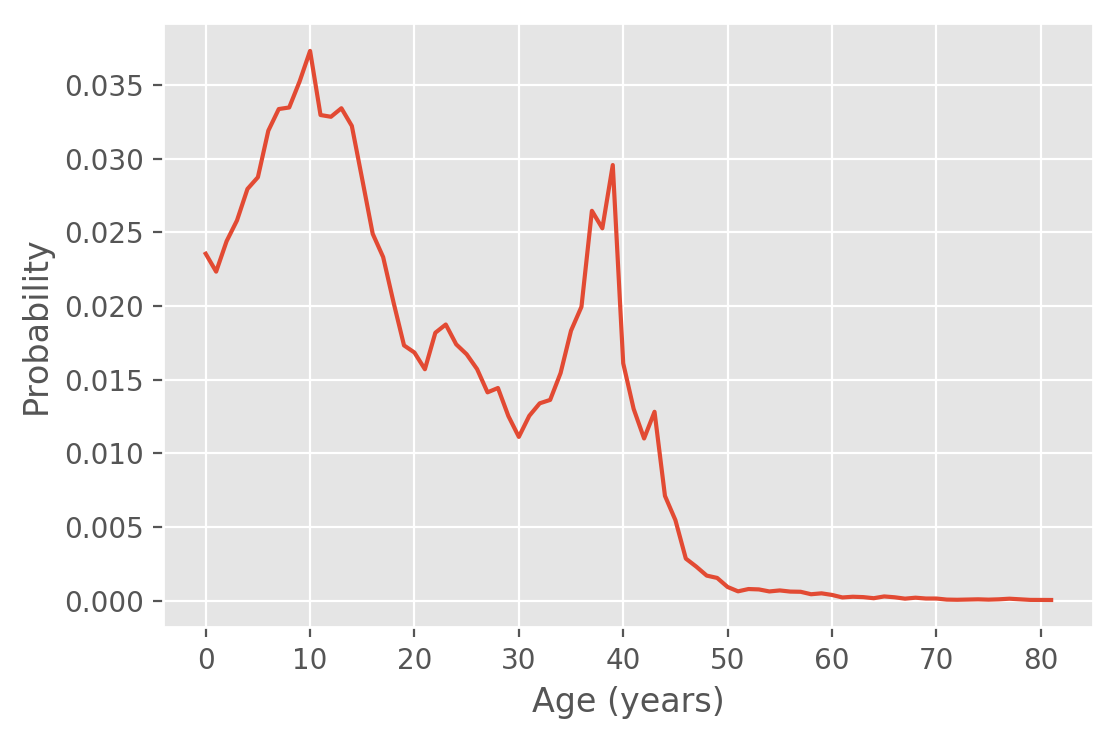

In [15]:
plt.figure(dpi=200)

plt.plot(damien['age'], damien['probability'])
plt.xlabel('Age (years)')
plt.ylabel('Probability');

In [16]:
def make_plot(name, gender):
    name_frame = naive_bayes(name, gender)
    gender_label = {'M': 'men', 'F': 'women'}
    
    plt.figure(dpi=200)
    plt.plot(name_frame['age'], name_frame['probability'])
    plt.title(f'Probability of age for {gender_label[gender]} named {name}')
    plt.xlabel('Age (years)')
    plt.ylabel('Probability');


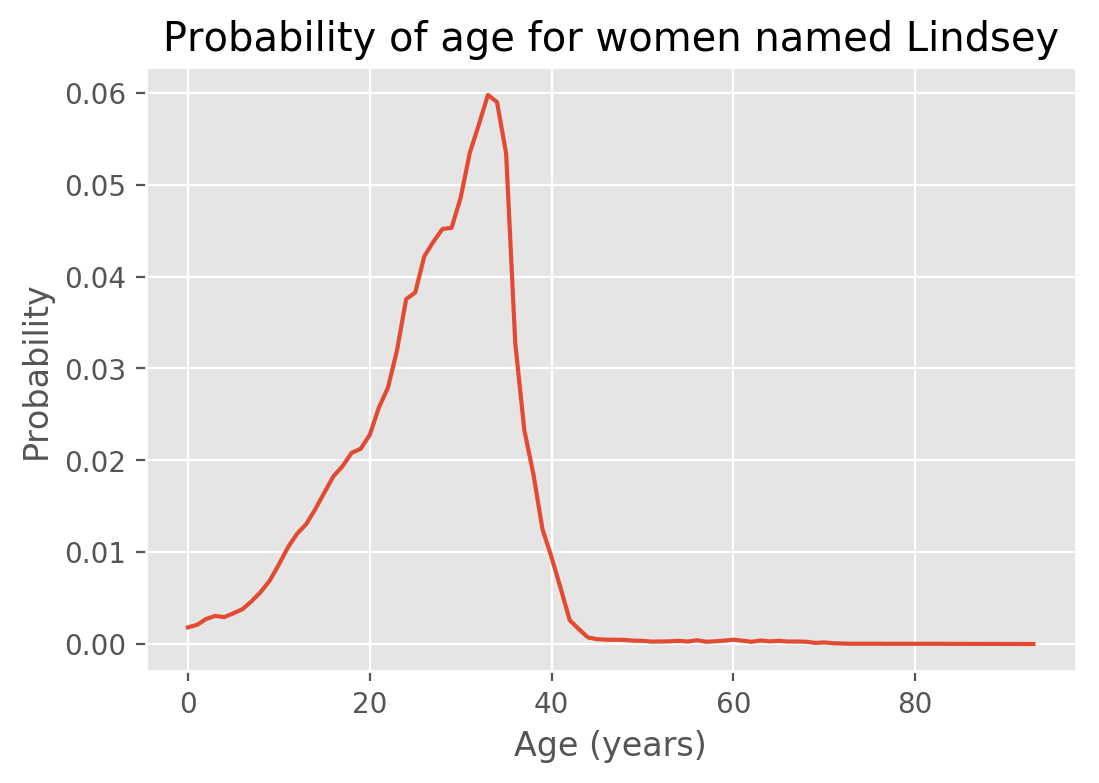

In [17]:
make_plot('Lindsey', 'F')


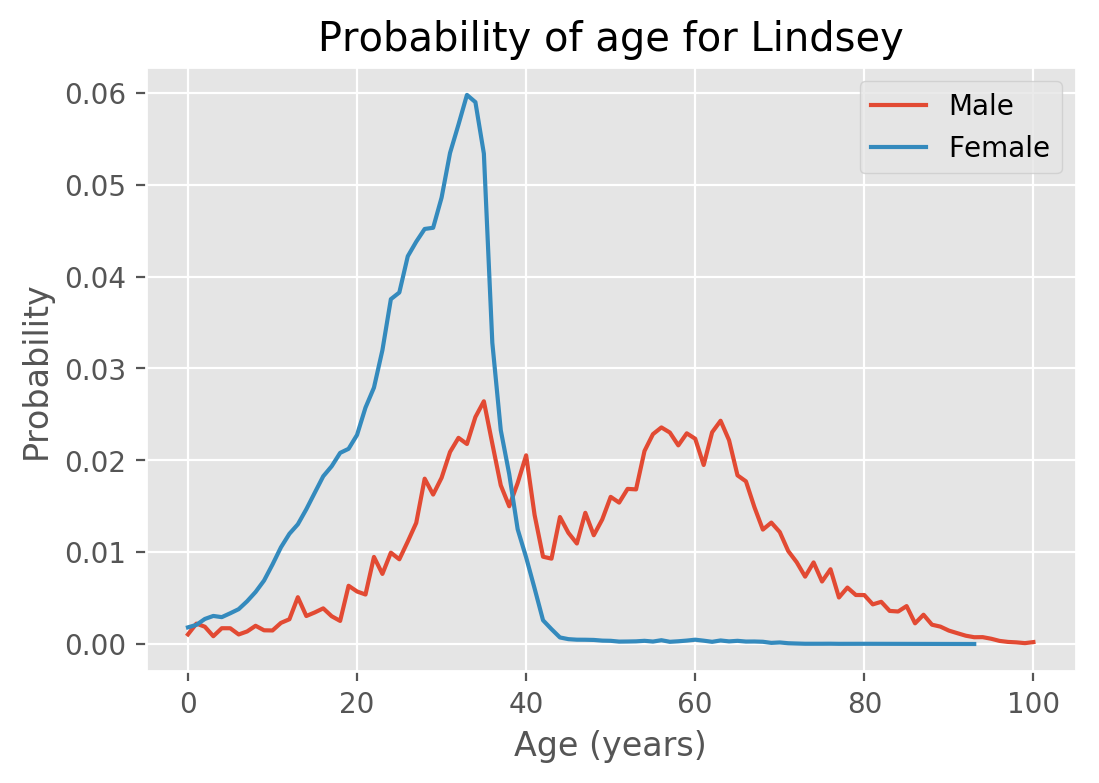

In [18]:
# Linsey is an interesting case, let's plot both on the same axis
lindsey_male = naive_bayes('Lindsey', 'M')
lindsey_female = naive_bayes('Lindsey', 'F')

plt.figure(dpi=200)
plt.plot(lindsey_male['age'], lindsey_male['probability'], label='Male')
plt.plot(lindsey_female['age'], lindsey_female['probability'], label='Female')

plt.title(f'Probability of age for Lindsey')
plt.xlabel('Age (years)')
plt.ylabel('Probability')
plt.legend();

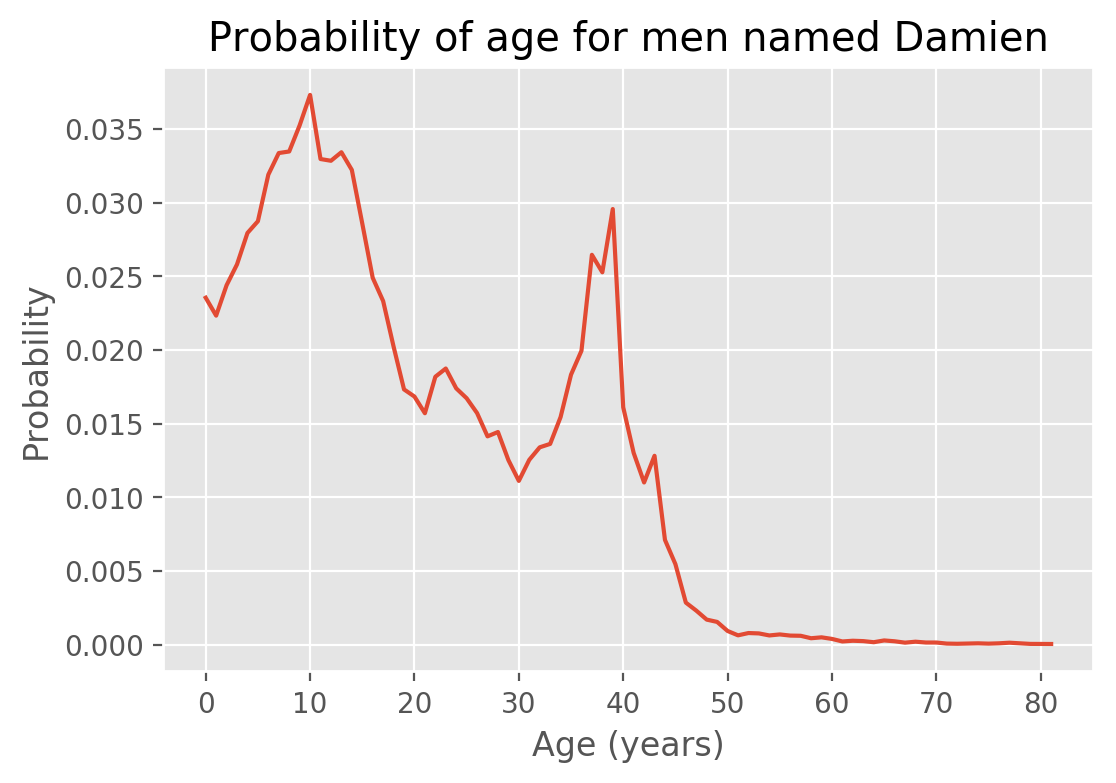

In [19]:
make_plot('Damien', 'M')

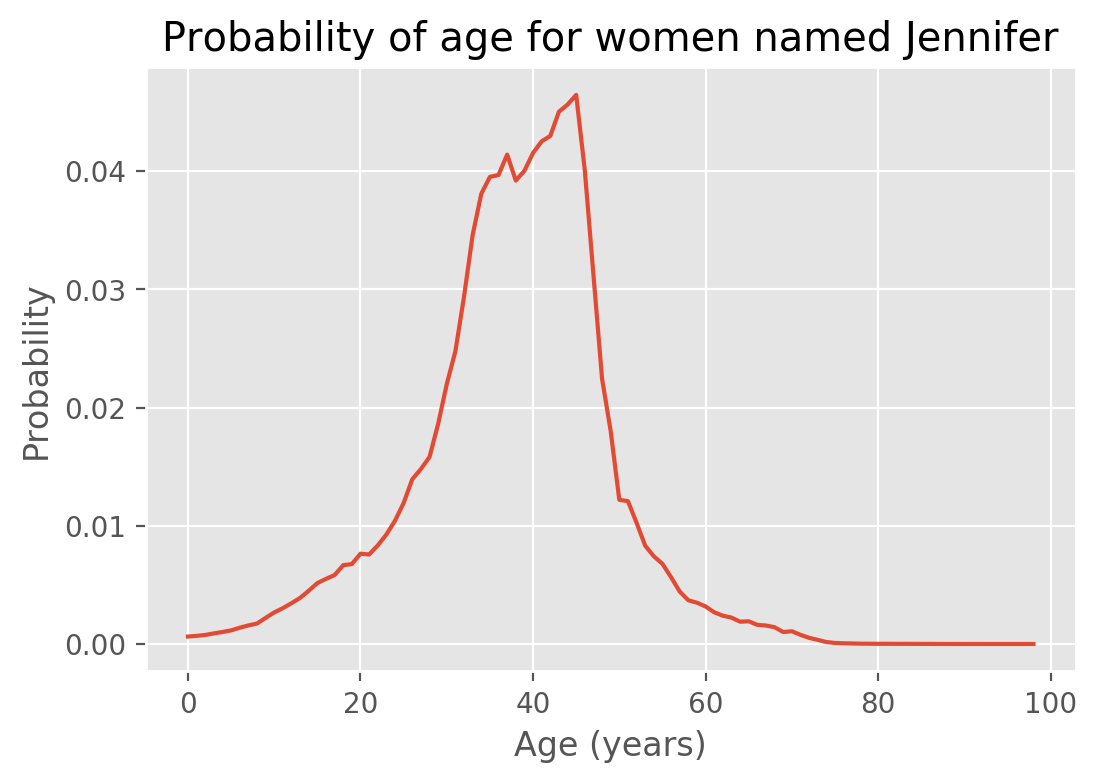

In [20]:
make_plot('Jennifer', 'F')

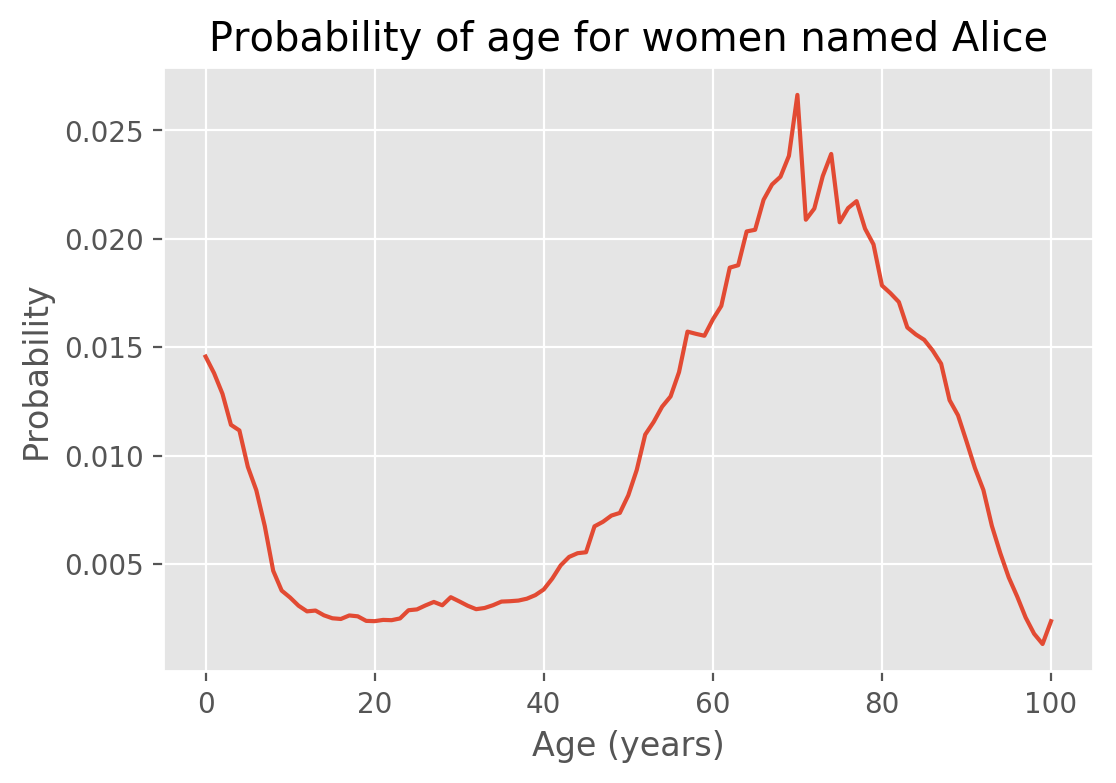

In [21]:
make_plot('Alice', 'F')

## Age quartiles

This section replicates the analysis done by Nate Silver in https://fivethirtyeight.com/features/how-to-tell-someones-age-when-all-you-know-is-her-name/. 

The detailed information with the actual age distribution for each age above is nice, but it is difficult to do ask questions about which names have certain properties (e.g. Which name is the "oldest"? Which name is the most informative about age?)

Note that we cannot use the functions `quartile` here because we already have bucketed ages and counts. We are forced to implement the quartile function ourselves.

In [22]:
long_age_dist2017 = (age_dist2017_clean
                         .rename(columns={'Male': 'M', 'Female': 'F'})
                         .melt(id_vars=['age'], value_vars=['F', 'M'], value_name='gender_age_prior')
                    )

In [23]:
long_age_dist2017.head()

,age,gender,gender_age_prior
0,0,F,0.011640
1,1,F,0.011757
2,2,F,0.011888
3,3,F,0.011834
4,4,F,0.011819


In [24]:
names_and_ages = pd.merge(name_df, long_age_dist2017)
names_and_ages.head()

,name,gender,count,year,age,fraction,gender_age_prior
0,Aaron,F,5,1917,100,0.000005,0.000413
1,Abbey,F,8,1917,100,0.000007,0.000413
2,Abbie,F,136,1917,100,0.000126,0.000413
3,Abby,F,11,1917,100,0.000010,0.000413
4,Abell,F,5,1917,100,0.000005,0.000413


There are quite a few "small" samples in this dataset. For example, there are a few males named Jennifer, which are preseumably typographical errors. We will count how popular a name / gender combo is, and eliminate those without enough support

In [25]:
names_and_ages['support'] = names_and_ages.groupby(['name', 'gender'])['count'].transform(sum)

In [26]:
min_support = 5000

names_and_ages = names_and_ages[names_and_ages['support'] > min_support]

Now that we have eliminated any name/gender combinations that have occurred fewer than 5000 times total, we can return to calculating the probabilities for the significant names.

In [27]:
names_and_ages['liklihood_prior'] = names_and_ages['fraction'] * names_and_ages['gender_age_prior']
names_and_ages['probability'] = names_and_ages.groupby(['name', 'gender'])['liklihood_prior'].transform(lambda row: row/row.sum())
names_and_ages.head()

,name,gender,count,year,age,fraction,gender_age_prior,support,liklihood_prior,probability
1,Abbey,F,8,1917,100,0.000007,0.000413,17139,3.059236e-09,0.000025
2,Abbie,F,136,1917,100,0.000126,0.000413,17767,5.200702e-08,0.000456
3,Abby,F,11,1917,100,0.000010,0.000413,57329,4.206450e-09,0.000010
5,Abigail,F,41,1917,100,0.000038,0.000413,355835,1.567859e-08,0.000006
6,Ada,F,1853,1917,100,0.001714,0.000413,56949,7.085956e-07,0.003015


In [28]:
names_and_ages[(names_and_ages['name'] == 'Damien') & (names_and_ages['gender'] == 'M')]['probability'].sum()

0.9999999999999999

In [29]:
#names_and_ages[(names_and_ages['name'] == 'Damien') & (names_and_ages['gender'] == 'M')].cumsum()
names_and_ages['percentile'] = names_and_ages.groupby(['name', 'gender'])['probability'].cumsum()

In [30]:
names_and_ages[(names_and_ages['name'] == 'Damien') & (names_and_ages['gender'] == 'M')].head()

,name,gender,count,year,age,fraction,gender_age_prior,support,liklihood_prior,probability,percentile
197475,Damien,M,6,1936,81,0.000006,0.003442,55576,1.991419e-08,0.000051,0.000051
215426,Damien,M,6,1938,79,0.000005,0.004144,55576,2.242244e-08,0.000058,0.000109
233399,Damien,M,13,1940,77,0.000011,0.004798,55576,5.381595e-08,0.000138,0.000247
242440,Damien,M,9,1941,76,0.000007,0.005158,55576,3.780274e-08,0.000097,0.000344
251816,Damien,M,7,1942,75,0.000005,0.005760,55576,2.919898e-08,0.000075,0.000419


In [31]:
names_and_ages.head()

,name,gender,count,year,age,fraction,gender_age_prior,support,liklihood_prior,probability,percentile
1,Abbey,F,8,1917,100,0.000007,0.000413,17139,3.059236e-09,0.000025,0.000025
2,Abbie,F,136,1917,100,0.000126,0.000413,17767,5.200702e-08,0.000456,0.000456
3,Abby,F,11,1917,100,0.000010,0.000413,57329,4.206450e-09,0.000010,0.000010
5,Abigail,F,41,1917,100,0.000038,0.000413,355835,1.567859e-08,0.000006,0.000006
6,Ada,F,1853,1917,100,0.001714,0.000413,56949,7.085956e-07,0.003015,0.003015


In [32]:
def get_percentile(percentile):
 return names_and_ages.groupby(['name', 'gender']).apply(lambda x: x.loc[abs(x['percentile'] - percentile).idxmin(), 'age'])

In [33]:
percentiles = [get_percentile(0.25), get_percentile(0.5), get_percentile(0.75)]

In [34]:
percentile_frame = pd.concat(percentiles, axis=1).rename(columns={0: '0.75', 1: '0.5', 2:'0.25'})
del percentiles

In [35]:
percentile_frame.loc[('Damien',), :]

,0.75,0.5,0.25
gender,,,
M,32,17,9


In [36]:
percentile_frame.loc[('Violet', ), :]

,0.75,0.5,0.25
gender,,,
F,70,10,4


In [37]:
percentile_frame.loc[('Lula', ), :]

,0.75,0.5,0.25
gender,,,
F,84,75,65


In [38]:
percentile_frame.loc[('Alice', ), :]

,0.75,0.5,0.25
gender,,,
F,78,67,51


In [39]:
percentile_frame.loc[('Lindsey', ), :]

,0.75,0.5,0.25
gender,,,
F,34,29,22
M,63,51,34


### Questions:

Which names are the "oldest", as measured by the 75th percentile?

In [40]:
percentile_frame['0.75'].sort_values(ascending=False).head(10)

name      gender
Lucile    F         89
Gertrude  F         89
Seymour   M         88
Imogene   F         88
Berniece  F         88
Myrtle    F         87
Florence  F         87
Madge     F         87
Opal      F         87
Nannie    F         87
Name: 0.75, dtype: int64

Which names are most informative about ages? We will use the IQR as the measure here

In [41]:
(percentile_frame['0.75'] - percentile_frame['0.25']).sort_values().head(15)

name       gender
Daleyza    F         2
Everly     F         2
Jayceon    M         2
Shaquille  M         2
Bentley    M         3
Jase       M         3
Paislee    F         3
Krystle    F         3
Kyrie      M         3
Adalynn    F         3
Aria       F         3
Harper     F         3
Thiago     M         3
Iker       M         3
Sheena     F         4
dtype: int64

Are these all younger people?

In [42]:
small_iqr = (percentile_frame['0.75'] - percentile_frame['0.25']).sort_values().head(15).index
percentile_frame.loc[small_iqr]

,,0.75,0.5,0.25
name,gender,,,
Daleyza,F,3,2,1
Everly,F,3,2,1
Jayceon,M,4,3,2
Shaquille,M,25,24,23
Bentley,M,6,5,3
Jase,M,6,4,3
Paislee,F,4,3,1
Krystle,F,33,32,30
Kyrie,M,4,2,1


Yes, with the exception of Sheena, Krystle, and Shaquille, these are all names that are relatively "young".

Which names are _least_ informative about age, as measured by the IQR?

In [43]:
(percentile_frame['0.75'] - percentile_frame['0.25']).sort_values(ascending=False).head(15)

name        gender
Olive       F         74
Hazel       F         74
Eloise      F         72
Zola        F         71
Eleanor     F         70
Vada        F         70
Willa       F         68
Zella       F         68
Mazie       F         67
Ophelia     F         67
Clementine  F         66
Lola        F         66
Violet      F         66
Zelda       F         65
Clara       F         65
dtype: int64

In [44]:
percentile_frame.loc['Vada']

,0.75,0.5,0.25
gender,,,
F,75,40,5


In [45]:
names_and_ages[names_and_ages['name']=='Vada']

,name,gender,count,year,age,fraction,gender_age_prior,support,liklihood_prior,probability,percentile
4888,Vada,F,191,1917,100,0.000177,0.000413,7834,7.303927e-08,0.002159,0.002159
15046,Vada,F,220,1918,99,0.000190,0.000233,7834,4.434104e-08,0.001310,0.003469
25414,Vada,F,216,1919,98,0.000191,0.000322,7834,6.150502e-08,0.001818,0.005287
35960,Vada,F,194,1920,97,0.000162,0.000465,7834,7.528654e-08,0.002225,0.007512
46818,Vada,F,212,1921,96,0.000172,0.000641,7834,1.102109e-07,0.003257,0.010769
57608,Vada,F,180,1922,95,0.000150,0.000829,7834,1.241948e-07,0.003671,0.014440
68330,Vada,F,185,1923,94,0.000153,0.001040,7834,1.595587e-07,0.004716,0.019156
79122,Vada,F,200,1924,93,0.000160,0.001300,7834,2.081834e-07,0.006153,0.025308
89877,Vada,F,263,1925,92,0.000216,0.001572,7834,3.395310e-07,0.010035,0.035343
100358,Vada,F,164,1926,91,0.000138,0.001811,7834,2.505425e-07,0.007405,0.042748


Note that my data set contains some rare names, compared to Nate's. He used a support of 10000, rather than my 5000. Note that `Vada` did receive a kick upward after 1991 (release of _My Girl_) and the relatively low usage of the name before that contributes heavily to this name having a large IQR.

## Data export to json

Now let's export the name data to the following format:
```
[
  { 'name': 'Vada',
    'gender': 'F',
    'quartiles': [5, 40, 75],
    'probs': [(0, 0.053254), (1,0.060476),......]
  }, ...
]
```
This should make it easy to plot using D3 and a lookup.

In [46]:
def list_ages(grp):
    """We round the probabilities, because we are only using them to plot"""
    return sorted(zip(grp['age'], round(grp['probability'], 4)))

percentile_frame['probs'] = names_and_ages.groupby(['name', 'gender']).apply(list_ages)
percentile_frame['quartiles'] = percentile_frame.apply(lambda x: [x['0.25'], x['0.5'], x['0.75']], axis=1)
percentile_frame.drop(['0.25', '0.5', '0.75'], axis=1, inplace=True)
#sorted(zip(names_and_ages[names_and_ages['name']=='Vada']['age'],names_and_ages[names_and_ages['name']=='Vada']['probability'] ))

In [47]:
# Check the format
percentile_frame.head(3).reset_index().to_dict(orient='records')

[{'gender': 'F',
  'name': 'Aaliyah',
  'probs': [(0, 0.0501),
   (1, 0.0547),
   (2, 0.0575),
   (3, 0.0574),
   (4, 0.0626),
   (5, 0.0657),
   (6, 0.0617),
   (7, 0.0557),
   (8, 0.0506),
   (9, 0.0468),
   (10, 0.0453),
   (11, 0.043),
   (12, 0.0407),
   (13, 0.0415),
   (14, 0.0436),
   (15, 0.0575),
   (16, 0.0413),
   (17, 0.0185),
   (18, 0.0136),
   (19, 0.0176),
   (20, 0.0224),
   (21, 0.0107),
   (22, 0.0165),
   (23, 0.0191),
   (24, 0.0003),
   (25, 0.0003),
   (26, 0.0002),
   (27, 0.0002),
   (28, 0.0002),
   (29, 0.0002),
   (30, 0.0002),
   (31, 0.0002),
   (32, 0.0001),
   (33, 0.0003),
   (34, 0.0003),
   (35, 0.0004),
   (36, 0.0004),
   (37, 0.0006),
   (38, 0.0005),
   (39, 0.0007),
   (40, 0.0006),
   (41, 0.0003)],
  'quartiles': [4, 9, 14]},
 {'gender': 'M',
  'name': 'Aaron',
  'probs': [(0, 0.0122),
   (1, 0.0119),
   (2, 0.0119),
   (3, 0.0123),
   (4, 0.0122),
   (5, 0.0126),
   (6, 0.0129),
   (7, 0.0124),
   (8, 0.0128),
   (9, 0.0138),
   (10, 0.0143),

In [48]:
# Write to json
import json

with open('data/processed.json', 'w') as output_handle:
    json.dump(percentile_frame.reset_index().to_dict(orient='records'), output_handle)